# Boo3 Review
    Here I'll compile all of my sims for the orbit & tidal stream for Boo3. I'll be using a mass of 1e6Msol, disruption time of 3Gyr, 500x2 simulated stars, Kevin's 6D data, and I'll run the simulation once for MWPotential2014, and maybe again for the McMillan17 potential. I'll also be including Kevin's RRL & BHB star data, as well as the Grillmair Styx stream data points.

In [11]:
from galpy.orbit import Orbit
from galpy import potential
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
from IPython.display import HTML
from galpy.potential import MWPotential2014,ChandrasekharDynamicalFrictionForce,HernquistPotential,MovingObjectPotential
from galpy.potential.mwpotentials import McMillan17
from galpy.util import conversion
from streamtools.df import streamspraydf
from astropy import units

from stream_package.stream_package import graphics

In [22]:
import pickle
filehandler = open('boo3_stream.obj', 'rb') 
obj = pickle.load(filehandler)

stream_lmc17 = obj.get("lmc17")
otrail_lmc17 = stream_lmc17['trail']
olead_lmc17 = stream_lmc17['lead']
oall_lmc17 = stream_lmc17['all']

stream_17 = obj.get("17")
otrail17 = stream_17['trail']
olead17 = stream_17['lead']
oall17 = stream_17['all']

stream_lmc14 = obj.get("lmc14")
otrail_lmc14 = stream_lmc14['trail']
olead_lmc14 = stream_lmc14['lead']
oall_lmc14 = stream_lmc14['all']

stream_14 = obj.get('14')
otrailing14 = stream_14['trail']
oleading14 = stream_14['lead']
oall14 = stream_14['all']

## With MWPotential2014

In [2]:
pot14 = MWPotential2014
mass = 1e6

ro = conversion.get_physical(MWPotential2014)['ro']
vo = conversion.get_physical(MWPotential2014)['vo']
to = conversion.time_in_Gyr(ro=ro, vo=vo)
mo = conversion.mass_in_msol(ro=ro, vo=vo)
tdis = 3
nstar = 500

sixD_kevin_means = [209.3, 26.8, 46.5, -1.16, -0.88, 189.8]
o = Orbit(vxvv = sixD_kevin_means, ro=ro, vo=vo, solarmotion = [-11.1, 24.0, 7.25], radec=True)
o.turn_physical_off()

### Without LMC inclusion

In [3]:
oall14, oleading14, otrailing14, dtall14, dt14, dtt14 = graphics.streamorbits(mass, o, tdis, pot=pot14, nstar=nstar)

In [9]:
ob_14 = Orbit(vxvv = sixD_kevin_means, ro=ro, vo=vo, solarmotion = [-11.1, 24.0, 7.25], radec=True)
tsb = np.linspace(0, -tdis/to, 501)
ob_14.integrate(tsb, pot=pot14)
of_14 = Orbit(vxvv = sixD_kevin_means, ro=ro, vo=vo, solarmotion = [-11.1, 24.0, 7.25], radec=True)
tsf = np.linspace(0, tdis/to, 501)
of_14.integrate(tsf, pot=pot14)

### LMC inclusion

In [4]:
o_lmc14, oall_lmc14, olead_lmc14, otrail_lmc14, dtall_lmc14 = graphics.streamorbitslmc_acc_lt(mass, o, tdis, pot=pot14, nstar=nstar)

In [45]:
MWpotLMC = graphics.lmc_potential_wacc(tdisrupt, pot=pot14)

ob_14lmc = Orbit(vxvv = sixD_kevin_means, ro=ro, vo=vo, solarmotion = [-11.1, 24.0, 7.25], radec=True)
tsb = np.linspace(0, -tdis/to, 501)
ob_14lmc.integrate(tsb, pot=MWpotLMC)
of_14lmc = Orbit(vxvv = sixD_kevin_means, ro=ro, vo=vo, solarmotion = [-11.1, 24.0, 7.25], radec=True)
tsf = np.linspace(0, tdis/to, 501)
of_14lmc.integrate(tsf, pot=MWpotLMC)

## With McMillan17

In [15]:
pot17 = McMillan17
mass = 1e6

ro17 = conversion.get_physical(McMillan17)['ro']
vo17 = conversion.get_physical(McMillan17)['vo']
to17 = conversion.time_in_Gyr(ro=ro17, vo=vo17)
mo17 = conversion.mass_in_msol(ro=ro17, vo=vo17)
tdis = 3
nstar = 500

sixD_kevin_means = [209.3, 26.8, 46.5, -1.16, -0.88, 189.8]
o17 = Orbit(vxvv = sixD_kevin_means, ro=ro17, vo=vo17, solarmotion = [-11.1, 24.0, 7.25], radec=True)
o17.turn_physical_off()

In [17]:
tdisrupt=10

olmc= Orbit.from_name('LMC', ro=ro17, vo=vo17)
cdf= ChandrasekharDynamicalFrictionForce(GMs=10.**11.*units.Msun,rhm=5.*units.kpc,
                                             dens=pot17[1], ro=ro17, vo=vo17)
ts= np.linspace(0.,-tdisrupt,1001)*units.Gyr
olmc.integrate(ts,pot17+cdf)

lmcpot= HernquistPotential(amp=2*10.**11.*units.Msun,
                           a=5.*units.kpc/(1.+np.sqrt(2.))) #rhm = (1+sqrt(2)) a
moving_lmcpot= MovingObjectPotential(olmc,pot=lmcpot)

from galpy.potential import (evaluateRforces, evaluatephitorques,
                             evaluatezforces)
loc_origin= 1e-4 # Small offset in R to avoid numerical issues
ax= lambda t: evaluateRforces(moving_lmcpot,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)
ay= lambda t: evaluatephitorques(moving_lmcpot,loc_origin,0.,phi=0.,t=t,
                                    use_physical=False)/loc_origin
az= lambda t: evaluatezforces(moving_lmcpot,loc_origin,0.,phi=0.,t=t,
                                  use_physical=False)

t_intunits= olmc.time(use_physical=False)[::-1] # need to reverse the order for interp
ax4int= np.array([ax(t) for t in t_intunits])
ax_int= lambda t: np.interp(t,t_intunits,ax4int)
ay4int= np.array([ay(t) for t in t_intunits])
ay_int= lambda t: np.interp(t,t_intunits,ay4int)
az4int= np.array([az(t) for t in t_intunits])
az_int= lambda t: np.interp(t,t_intunits,az4int)

from galpy.potential import NonInertialFrameForce
nip= NonInertialFrameForce(a0=[ax_int,ay_int,az_int])

### Not including LMC

In [19]:
spdf= streamspraydf(mass/mo17,
                   progenitor=o17,
                   pot=pot17,
                   tdisrupt=tdisrupt/to17)

spdft= streamspraydf(mass/mo17,
                   progenitor=o17,
                   pot=pot17,
                   tdisrupt=tdisrupt/to17,
                   leading=False)

RvR,dt= spdf.sample(n=nstar,returndt=True,integrate=True)
RvRt,dtt= spdft.sample(n=nstar,returndt=True,integrate=True)

vxvva=np.column_stack([np.append(RvR[0],RvRt[0]),
                       np.append(RvR[1],RvRt[1]),
                       np.append(RvR[2],RvRt[2]),
                       np.append(RvR[3],RvRt[3]),
                       np.append(RvR[4],RvRt[4]),
                       np.append(RvR[5],RvRt[5])])

vxvv=np.column_stack([RvR[0],RvR[1],RvR[2],RvR[3],RvR[4],RvR[5]])
vxvvt=np.column_stack([RvRt[0],RvRt[1],RvRt[2],RvRt[3],RvRt[4],RvRt[5]])

olead17=Orbit(vxvv,ro=ro17,vo=vo17,solarmotion=[-11.1, 24.0, 7.25])
otrail17=Orbit(vxvvt,ro=ro17,vo=vo17,solarmotion=[-11.1, 24.0, 7.25])

oall17=Orbit(vxvva,ro=ro17,vo=vo17,solarmotion=[-11.1, 24.0, 7.25])
dtall17=np.append(dt,dtt)

In [34]:
ob_17 = Orbit(vxvv = sixD_kevin_means, ro=ro17, vo=vo17, solarmotion = [-11.1, 24.0, 7.25], radec=True)
tsb = np.linspace(0, -tdis/to, 501)
ob_17.integrate(tsb, pot=pot17)
of_17 = Orbit(vxvv = sixD_kevin_means, ro=ro17, vo=vo17, solarmotion = [-11.1, 24.0, 7.25], radec=True)
tsf = np.linspace(0, tdis/to, 501)
of_17.integrate(tsf, pot=pot17)

### Including LMC

In [ ]:
total_pot = pot17 + moving_lmcpot + nip

In [18]:
spdf_lmc= streamspraydf(mass/mo17,
                   progenitor=o17,
                   pot=total_pot,
                   tdisrupt=tdisrupt/to17,
                   rtpot=pot17)

spdft_lmc= streamspraydf(mass/mo17,
                   progenitor=o17,
                   pot=total_pot,
                   tdisrupt=tdisrupt/to17,
                   rtpot=pot17,
                   leading=False)

RvR_lmc,dt_lmc= spdf_lmc.sample(n=nstar,returndt=True,integrate=True)
RvRt_lmc,dtt_lmc= spdft_lmc.sample(n=nstar,returndt=True,integrate=True)

vxvva_lmc=np.column_stack([np.append(RvR_lmc[0],RvRt_lmc[0]),
                       np.append(RvR_lmc[1],RvRt_lmc[1]),
                       np.append(RvR_lmc[2],RvRt_lmc[2]),
                       np.append(RvR_lmc[3],RvRt_lmc[3]),
                       np.append(RvR_lmc[4],RvRt_lmc[4]),
                       np.append(RvR_lmc[5],RvRt_lmc[5])])

vxvv=np.column_stack([RvR_lmc[0],RvR_lmc[1],RvR_lmc[2],RvR_lmc[3],RvR_lmc[4],RvR_lmc[5]])
vxvvt=np.column_stack([RvRt_lmc[0],RvRt_lmc[1],RvRt_lmc[2],RvRt_lmc[3],RvRt_lmc[4],RvRt_lmc[5]])

olead_lmc17=Orbit(vxvv,ro=ro17,vo=vo17,solarmotion=[-11.1, 24.0, 7.25])
otrail_lmc17=Orbit(vxvvt,ro=ro17,vo=vo17,solarmotion=[-11.1, 24.0, 7.25])

oall_lmc17=Orbit(vxvva_lmc,ro=ro17,vo=vo17,solarmotion=[-11.1, 24.0, 7.25])
dtall_lmc17=np.append(dt_lmc,dtt_lmc)

In [35]:
ob_17lmc = Orbit(vxvv = sixD_kevin_means, ro=ro17, vo=vo17, solarmotion = [-11.1, 24.0, 7.25], radec=True)
tsb = np.linspace(0, -tdis/to, 501)
ob_17lmc.integrate(tsb, pot=total_pot)
of_17lmc = Orbit(vxvv = sixD_kevin_means, ro=ro17, vo=vo17, solarmotion = [-11.1, 24.0, 7.25], radec=True)
tsf = np.linspace(0, tdis/to, 501)
of_17lmc.integrate(tsf, pot=total_pot)

In [20]:
import pickle
#file_streams = open('boo3_stream.obj', 'wb')

stream_lmc17 = {
    "trail" : otrail_lmc17,
    "lead" : olead_lmc17,
    "all" : oall_lmc17
}
stream_17 = {
    "trail" : otrail17,
    "lead" : olead17,
    "all" : oall17
}
stream_lmc14 = {
    "trail" : otrail_lmc14,
    "lead" : olead_lmc14,
    "all" : oall_lmc14    
}
stream_14 = {
    "trail" : otrailing14,
    "lead" : oleading14,
    "all" : oall14
}

streams_dict = {
    "lmc17" : stream_lmc17,
    "17" : stream_17,
    "lmc14" : stream_lmc14,
    "14" : stream_14
}

#pickle.dump(streams_dict, file_streams)
#file_streams.close()

## Using the BHB & RRL sample:

In [23]:
import pandas as pd

data = pd.read_csv(r"boo3_combined.csv",sep='\s+')

In [25]:
data['s5_rrl'].to_list()[23:26]
data['gaia'].to_list()[26:]

dist_BHB = data['distance_pc'].to_list()[26:]
dist_BHB = [x/1000 for x in dist_BHB] #in kpc
ra_BHB = data['ra'].to_list()[26:] #in deg
dec_BHB = data['dec'].to_list()[26:] #in deg

dist_RRL = data['distance_pc'].to_list()[23:26]
dist_RRL = [x/1000 for x in dist_RRL] #in kpc
ra_RRL = data['ra'].to_list()[23:26] #in deg
dec_RRL = data['dec'].to_list()[23:26] #in deg

## Plotting 6D info:

In [30]:
def gen_plot(ointb, ointf, oall, o):
    indx = (oall.ra() < 213) & (oall.ra() > 206) & (oall.dec() < 29) & (oall.dec() > 24.5)
    
    fig = plt.figure(figsize=(12,15))
    ax1 = fig.add_subplot(321)
    ax2 = fig.add_subplot(322)
    ax3 = fig.add_subplot(323)
    ax4 = fig.add_subplot(324)
    
    ax1.scatter(oall.ra(), oall.dec());
    ax1.plot(o.ra(), o.dec(), "ro", label='Boo3');
    ax1.plot(ointb.ra(tsb), ointb.dec(tsb), 'k-');
    ax1.plot(ointf.ra(tsf), ointf.dec(tsf), 'k--');
    ax1.set_xlim(213, 206)
    ax1.set_ylim(24.5, 29)
    ax1.set_title('Ra vs. Dec')
    ax1.set_xlabel('RA (deg)')
    ax1.set_ylabel('DEC (deg)')
    ax1.legend()
    ax1.minorticks_on()
    
    ax2.scatter(oall.ra()[indx], oall.vlos()[indx]);
    ax2.plot(o.ra(), o.vlos(), "ro", label='Boo3');
    ax2.plot(ointb.ra(tsb), ointb.vlos(tsb), 'k-');
    ax2.plot(ointf.ra(tsf), ointf.vlos(tsf), 'k--');
    ax2.set_xlim(213, 206)
    ax2.set_ylim(165, 230)
    ax2.set_title('Radial Velocity')
    ax2.set_xlabel('RA (deg)')
    ax2.set_ylabel('Radial Velocity (km/s)')
    ax2.legend()
    ax2.minorticks_on()
    
    ax3.scatter(oall.ra()[indx], oall.pmra()[indx]);
    ax3.plot(o.ra(), o.pmra(), "ro", label='Boo3');
    ax3.plot(ointb.ra(tsb)[:10], ointb.pmra(tsb)[:10], 'k-');
    ax3.plot(ointf.ra(tsf)[:100], ointf.pmra(tsf)[:100], 'k--');
    ax3.set_xlim(213, 206)
    ax3.set_ylim(-2, 0)
    ax3.set_title('Proper Motion (Ra)')
    ax3.set_xlabel('RA (deg)')
    ax3.set_ylabel('PMRA (mas/yr)')
    ax3.legend()
    ax3.minorticks_on()
    
    ax4.scatter(oall.ra()[indx], oall.pmdec()[indx]);
    ax4.plot(o.ra(), o.pmdec(), "ro", label='Boo3');
    ax4.plot(ointb.ra(tsb)[:10], ointb.pmdec(tsb)[:10], 'k-');
    ax4.plot(ointf.ra(tsf)[:100], ointf.pmdec(tsf)[:100], 'k--');
    ax4.set_xlim(213, 206)
    ax4.set_ylim(-2, 0)
    ax4.set_title('Proper Motion (Dec)')
    ax4.set_xlabel('RA (deg)')
    ax4.set_ylabel('PMDEC (mas/yr)')
    ax4.legend()
    ax4.minorticks_on()
    
    plt.tight_layout()
    #plt.show();

    
    
    #fig2 = plt.figure(figsize=(5,10))
    ax5 = fig.add_subplot(325)
    ax6 = fig.add_subplot(326)
    
    ax5.scatter(oall.pmra()[indx], oall.pmdec()[indx])
    ax5.scatter(o.pmra(), o.pmdec(), c='red', label='Boo3')
    ax5.plot(ointb.pmra(tsb)[:20], ointb.pmdec(tsb)[:20], 'k-');
    ax5.plot(ointf.pmra(tsf)[:150], ointf.pmdec(tsf)[:150], 'k--');
    ax5.legend()
    ax5.set_xlim(-2,0)
    ax5.set_ylim(-2,0)
    ax5.set_title('Proper Motions')
    ax5.set_xlabel('PMRA (mas/yr)')
    ax5.set_ylabel('PMDEC (mas/yr)')
    
    ax6.scatter(oall.ra()[indx], oall.dist()[indx]);
    ax6.scatter(o.ra(), o.dist(), c='red', label='Boo3');
    ax6.plot(ointb.ra(tsb), ointb.dist(tsb), 'k-');
    ax6.plot(ointf.ra(tsf), ointf.dist(tsf), 'k--');
    ax6.set_xlim(213, 206)
    ax6.set_ylim(30,60)
    ax6.legend()
    ax6.set_title('Distance')
    ax6.set_xlabel('RA (deg)')
    ax6.set_ylabel('Distance (kpc)')
    
    ax5.minorticks_on()
    ax6.minorticks_on()
    plt.show();
    return None

#### Plot for MWPotential2014 including LMC

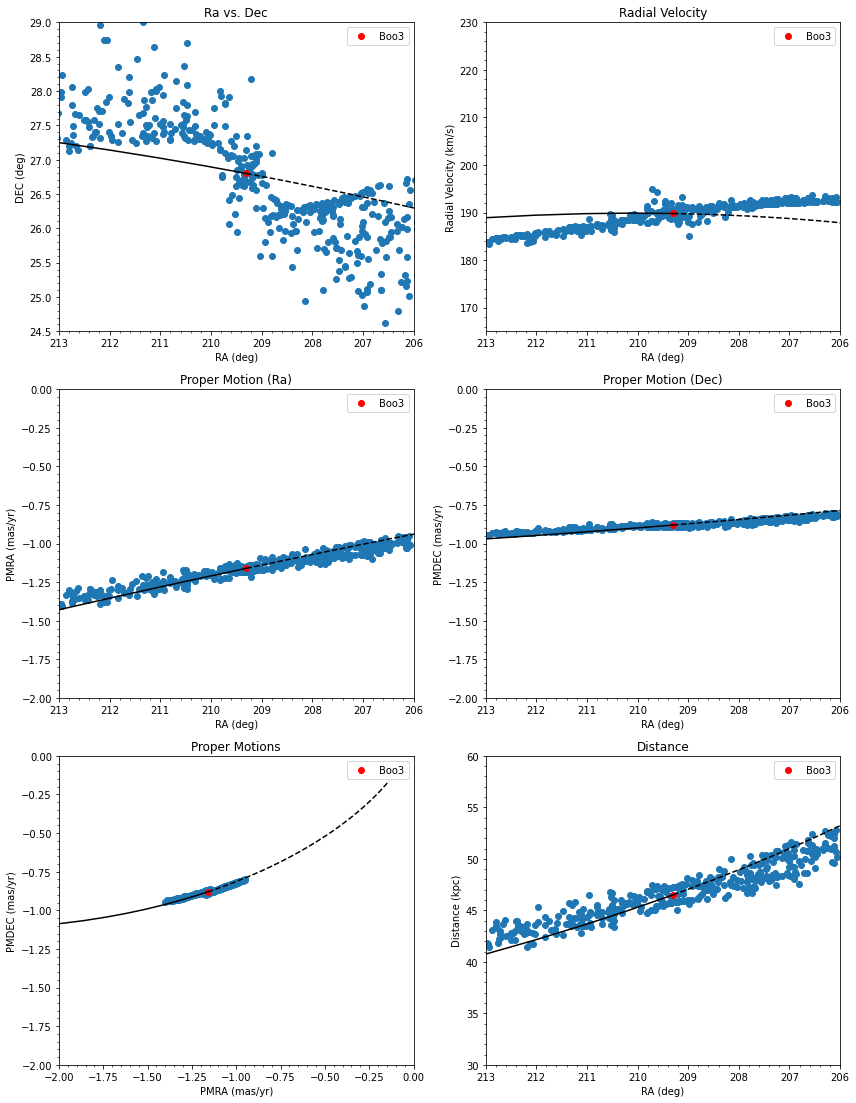

In [31]:
gen_plot(ob_14lmc, of_14lmc, oall_lmc14, o);

#### Plot for MWPotential2014 w/out LMC

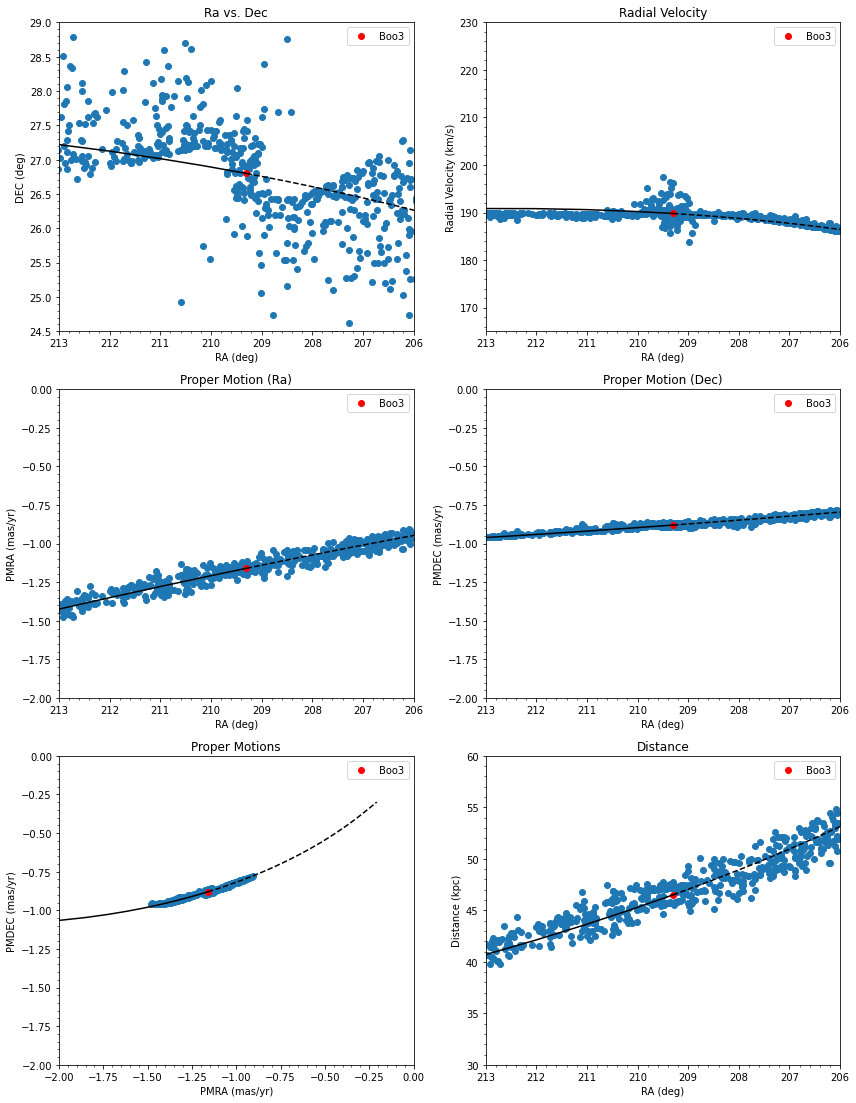

In [32]:
gen_plot(ob_14, of_14, oall14, o);

#### Plot for McMillan17 potential including LMC

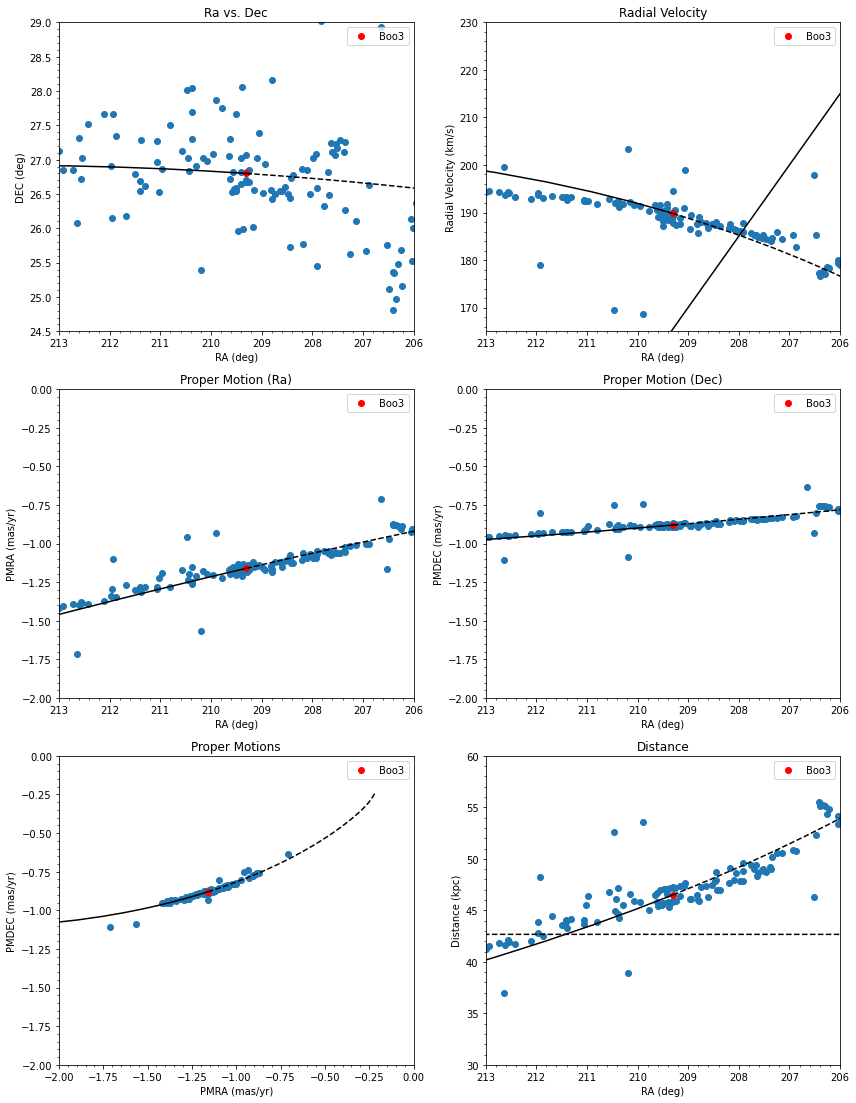

In [36]:
gen_plot(ob_17lmc, of_17lmc, oall_lmc17, o17);

#### Plot for McMillan17 potential not including LMC

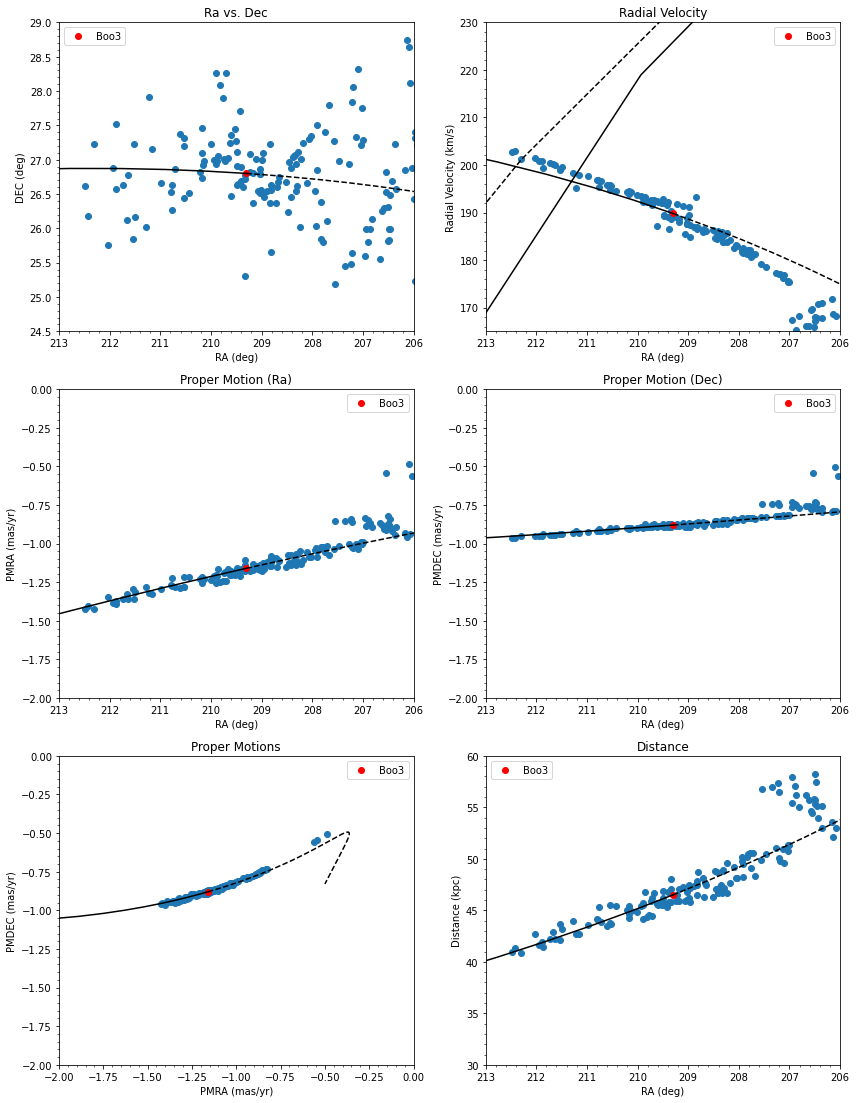

In [38]:
gen_plot(ob_17, of_17, oall17, o17);

## Plotting Boo3 MWPotential2014 w/ contours:

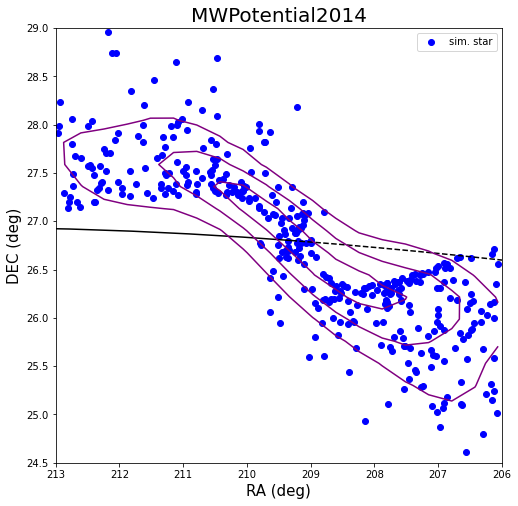

In [46]:
index = (oall_lmc14.ra() < 213) & (oall_lmc14.ra() > 206) & (oall_lmc14.dec() < 29) & (oall_lmc14.dec() > 24.5)

plt.figure(figsize=(8,8))
plt.scatter(oall_lmc14.ra()[index], oall_lmc14.dec()[index], c='blue', label='sim. star')

plt.plot(ob_14lmc.ra(tsb)[:20], ob_14lmc.dec(tsb)[:20], 'k-');
plt.plot(of_14lmc.ra(tsf)[:150], of_14lmc.dec(tsf)[:150], 'k--');

####
x = np.array(oall_lmc14.ra())[index]
y = np.array(oall_lmc14.dec())[index]
stack = np.vstack((x, y))

from scipy.stats import kde
k = kde.gaussian_kde(stack)
xi, yi = np.mgrid[x.min():x.max():20*1j, y.min():y.max():20*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

plt.contour(xi, yi, zi.reshape(xi.shape), levels=3, colors='purple')

####

plt.xlim(213, 206)
plt.ylim(24.5, 29)
plt.xlabel('RA (deg)', size=15)
plt.ylabel('DEC (deg)', size=15)
plt.title('MWPotential2014', size=20)
plt.legend()